The aim of this notebook is to auto segment the carries using k-mean clustering

In [134]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import seaborn as sns

In [135]:
# assigning the cleaned data to the data variable
data = r'clean_data.csv'

In [136]:
#loading data as a dataframe - clean_df
clean_df = pd.read_csv(data)

In [137]:
#spot check - first 5 rows
clean_df.head()

,carrier_number,shipment_number,shipment_date,delivery_date,delivery_reliability,feedback_reliability,non_conformance_count,transport_mode,cost_usd,region,...,co2_emission_kg,shipment_weight_kg,first_carrier_name,carrier_number_name,year_month,price_per_distance,origin_postal_code_2_digit,destination_postal_code_2_digit,lane,country_lane
0,CR-904-C,SHP904437,2023-06-04,2023-06-10,1,1,0,Road,7965.47,Latin America,...,3556.43,3295.59,RoyalMail,CR-904-C-RoyalMail,2023-06,0.752659,30,76,CO30-->BR76,CO-->BR
1,CR-533-B,SHP499266,2024-04-07,2024-04-18,1,0,0,Sea,20696.89,Africa,...,10062.87,88103.65,Royal Mail,CR-533-B-Royal Mail,2024-04,0.367902,49,57,ZA49-->NG57,ZA-->NG
2,CR-970-A,SHP227384,2023-09-13,2023-09-16,1,0,0,Air,4455.99,Asia,...,1295.29,1499.37,USPS,CR-970-A-USPS,2023-09,0.323120,82,74,IN82-->JP74,IN-->JP
3,977970,SHP516508,2025-02-15,2025-02-26,0,0,0,Road,30704.21,Europe,...,6589.36,3105.12,XPO Logistics,977970-XPO Logistics,2025-02,0.383968,50,85,SE50-->ZA85,SE-->ZA
4,CR-601-A,SHP976649,2023-06-15,2023-06-19,1,1,0,Road,33841.75,North America,...,22588.48,24345.03,USPS,CR-601-A-USPS,2023-06,0.152318,98,77,MX98-->EG77,MX-->EG


In [138]:
#calculating total number of shipments and non conformance counts, and average KPI of each carrier; assiging to carrier_data variable
carrier_data = clean_df.groupby('carrier_number_name').agg({'shipment_number': 'nunique',
                                                            'delivery_reliability':'mean',
                                                            'feedback_reliability':'mean',
                                                            'non_conformance_count':'sum'
                                                            }).reset_index().sort_values(by='shipment_number', ascending=False)

In [139]:
# Spot Check
carrier_data

,carrier_number_name,shipment_number,delivery_reliability,feedback_reliability,non_conformance_count
2829,CR-292-B-ZIM,14,0.428571,0.571429,6
4001,CR-685-C-Zim,14,0.642857,0.500000,6
3164,CR-405-B-Zim,13,0.615385,0.615385,0
4573,CR-878-B-ZIM,13,0.538462,0.692308,6
4414,CR-825-A-ZIM,13,0.538462,0.692308,1
...,...,...,...,...,...
1471,690753-UPS,1,1.000000,1.000000,0
1470,690156-DBSchenker,1,1.000000,0.000000,0
1469,690115-Evergreen,1,1.000000,0.000000,0
1468,690023-SFExpress,1,1.000000,1.000000,1


In [140]:
#renaming column
carrier_data.rename(columns={'shipment_number':'number_of_shipments'}, inplace=True)

In [141]:
# creating the ncm_ratio column which divides the number of non conformance counts by the number of shipments
carrier_data['ncm_ratio'] = carrier_data['non_conformance_count']/carrier_data['number_of_shipments']

In [142]:
# spot checks
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923


In [143]:
#Selecting features for the kmeans cluster
select_features = carrier_data.drop('carrier_number_name', axis='columns')

In [144]:
#spot checks
select_features.head()

,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio
2829,14,0.428571,0.571429,6,0.428571
4001,14,0.642857,0.500000,6,0.428571
3164,13,0.615385,0.615385,0,0.000000
4573,13,0.538462,0.692308,6,0.461538
4414,13,0.538462,0.692308,1,0.076923


In [145]:
#saving column names of the select features
select_features_columns  = select_features.columns

In [146]:
#importing standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

In [147]:
# assigning the scaler to a variable
segment_scaler = StandardScaler()

In [148]:
#replacing inf with 0
select_features['ncm_ratio'] = np.where(np.isinf(select_features['ncm_ratio']),0, select_features['ncm_ratio'])

In [149]:
#transforming the select features using the standard scaler
select_features = segment_scaler.fit_transform(select_features)

In [150]:

#spot check
select_features

array([[ 4.48511272, -0.18597494,  0.17589409,  3.15508177,  0.16630665],
       [ 4.48511272,  0.36359876, -0.00729843,  3.15508177,  0.16630665],
       [ 4.07646414,  0.2931406 ,  0.28862795, -0.60616499, -0.51375363],
       ...,
       [-0.82731873,  1.27955495, -1.2896461 , -0.60616499, -0.51375363],
       [-0.82731873,  1.27955495,  1.27504924,  0.02070947,  1.0730537 ],
       [-0.82731873,  1.27955495, -1.2896461 , -0.60616499, -0.51375363]],
      shape=(4934, 5))

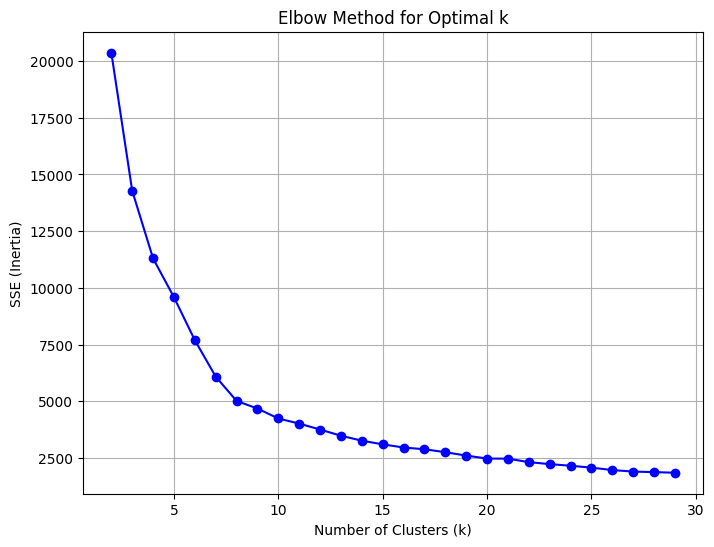

In [151]:
#plotting the cluster number v the sum of squared errors (SSE) for the Elbow Method
k= range(2,30)
sse = []

for n in k:
    kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
    kmeans.fit(select_features)
    inertia = kmeans.inertia_
    sse.append(inertia)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k, sse, 'bo-')  # Blue line with circles
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

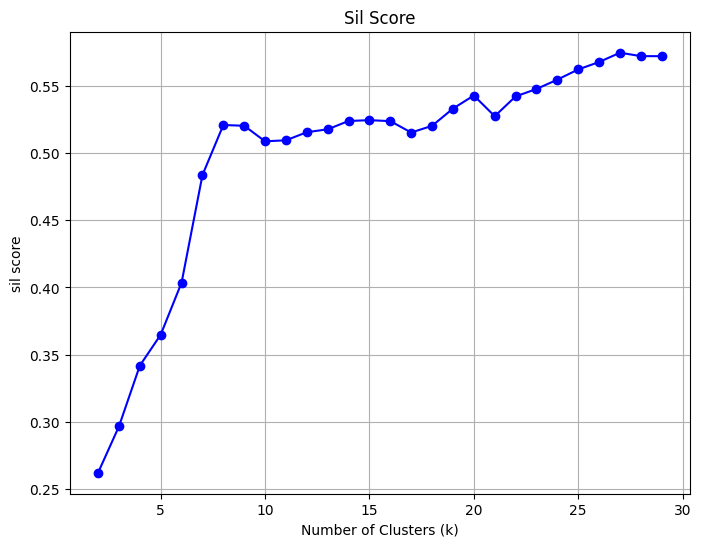

In [152]:
#plotting the cluster number v the silhouette score (sil score) 
sil_scores = []
k_range = range(2, 30)  # Start at 2
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(select_features)
    labels = kmeans.labels_  
    score = silhouette_score(select_features, labels)
    sil_scores.append(score)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, sil_scores, 'bo-')  
plt.xlabel('Number of Clusters (k)')
plt.ylabel('sil score')
plt.title('Sil Score')
plt.grid(True)
plt.show()

Based on the Elbow Method and the Silhouette Scores, I am choosing 8 clusters because the drop in SSE after the 8th cluster is minimal in comparison to those before the 8th cluster. The curve flattens afte 8. 

Also for the Silhouette Scores, the local peak as at the 8th cluster.

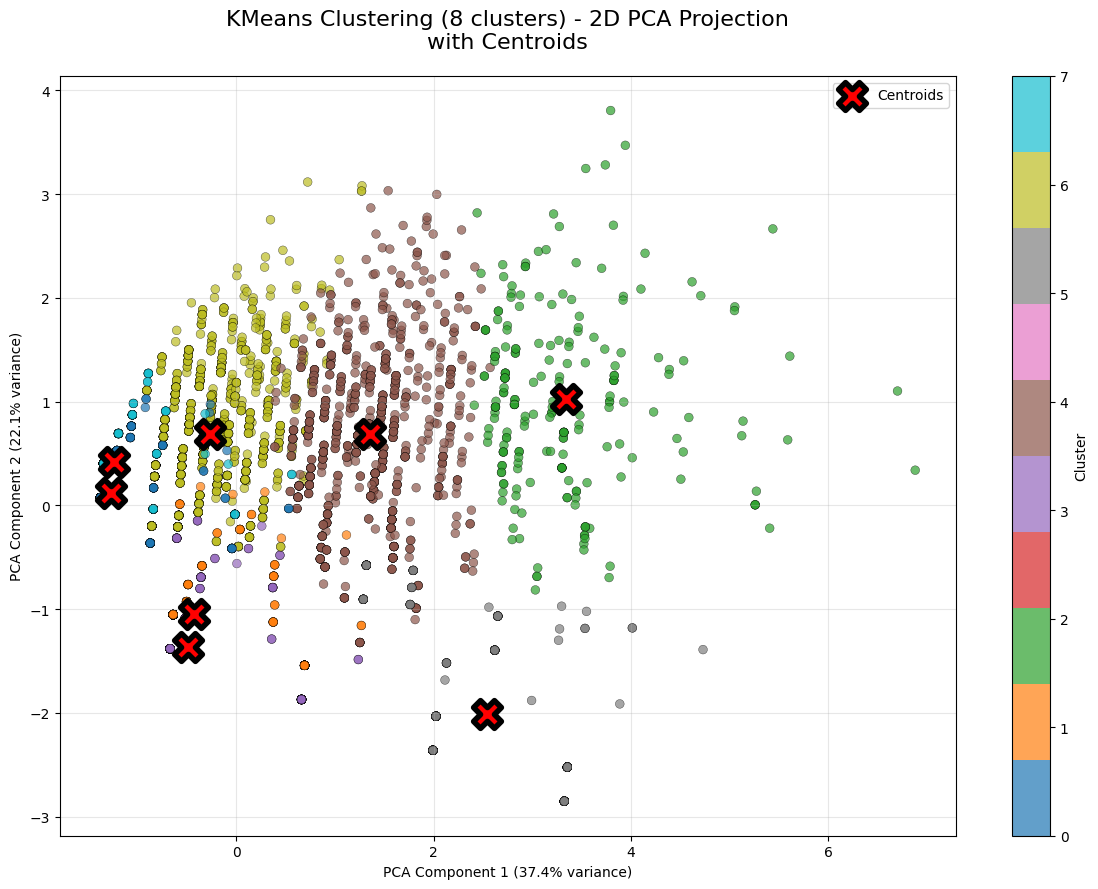

In [155]:
#building a 2D plot to see the clusters and centroids
segments = KMeans(n_clusters=8, n_init='auto', random_state=42)
labels = segments.fit_predict(select_features)   # get cluster labels

# Reduce data to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(select_features)

# Reduce centroids to the same 2D space
centroids_2d = pca.transform(segments.cluster_centers_)

# Plot
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                      c=labels, cmap='tab10', alpha=0.7, s=40, edgecolors='k', linewidth=0.3)

# Plot centroids as big red X's (or stars)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', marker='X', s=400, linewidths=4, label='Centroids', edgecolors='black', zorder=10)

# Optional: annotate cluster numbers on centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'  {i}', fontsize=14, fontweight='bold', color='white',
             ha='center', va='center')

plt.colorbar(scatter, label='Cluster')
plt.title('KMeans Clustering (8 clusters) - 2D PCA Projection\nwith Centroids', fontsize=16, pad=20)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Based on the image above, there are 4 main clusters and the other 4 are overlapping. Perhaps the it is worth comparing 8 clusters to 4 clusters

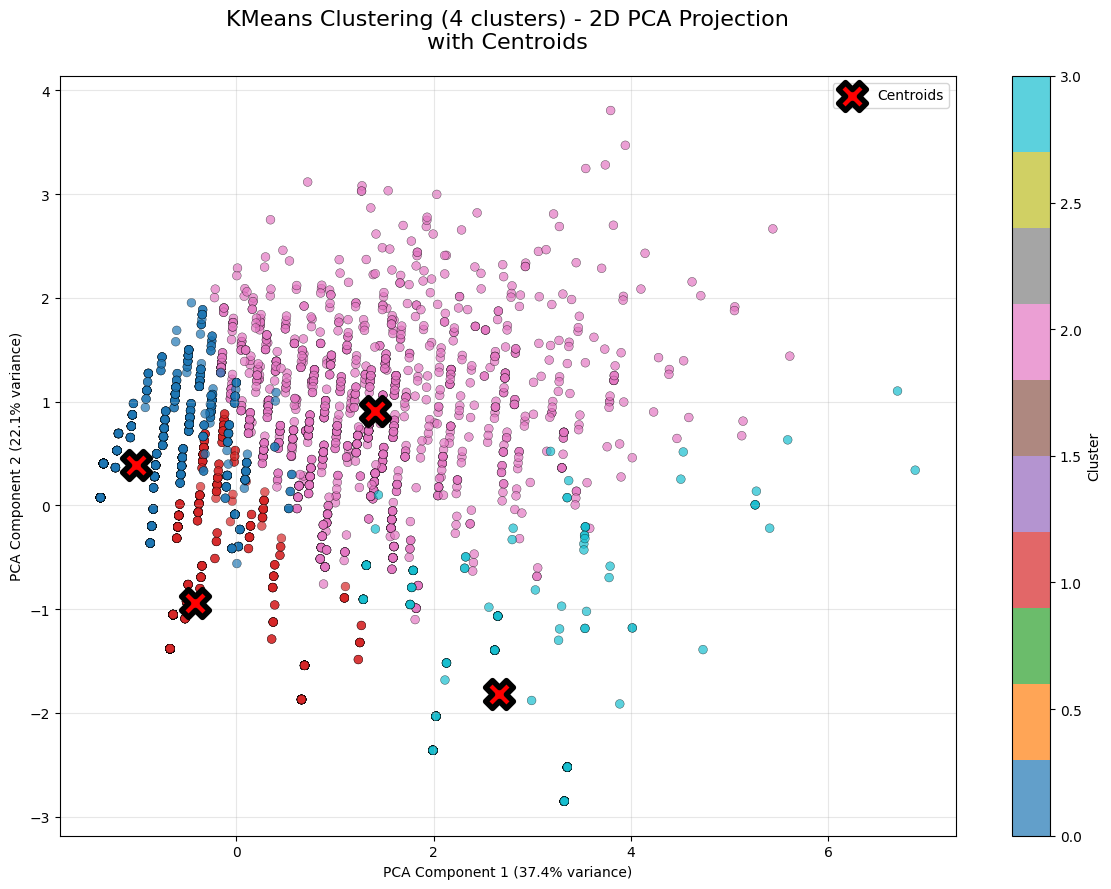

In [157]:

segments = KMeans(n_clusters=4, n_init='auto', random_state=42)
labels = segments.fit_predict(select_features)   # get cluster labels

# Reduce data to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(select_features)

# Reduce centroids to the same 2D space
centroids_2d = pca.transform(segments.cluster_centers_)

# Plot
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                      c=labels, cmap='tab10', alpha=0.7, s=40, edgecolors='k', linewidth=0.3)

# Plot centroids as big red X's (or stars)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', marker='X', s=400, linewidths=4, label='Centroids', edgecolors='black', zorder=10)

# Optional: annotate cluster numbers on centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'  {i}', fontsize=14, fontweight='bold', color='white',
             ha='center', va='center')

plt.colorbar(scatter, label='Cluster')
plt.title('KMeans Clustering (4 clusters) - 2D PCA Projection\nwith Centroids', fontsize=16, pad=20)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

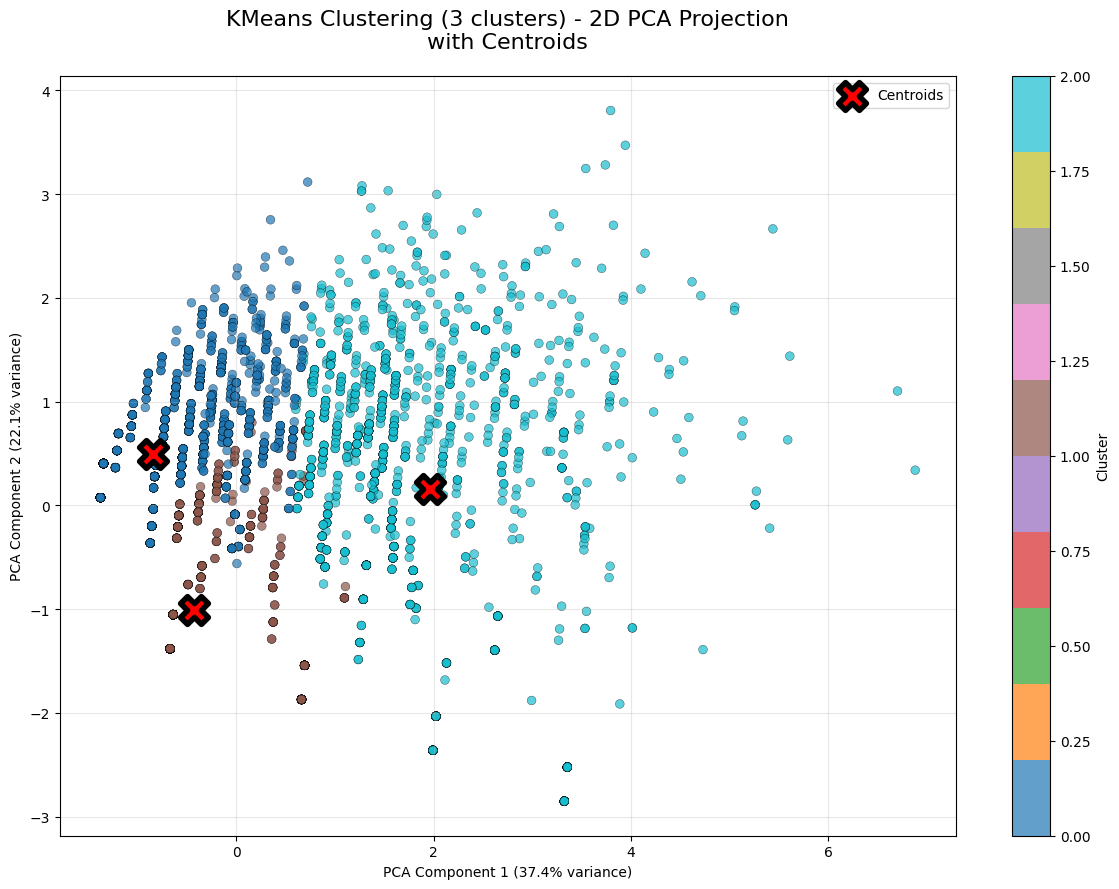

In [159]:

segments = KMeans(n_clusters=3, n_init='auto', random_state=42)
labels = segments.fit_predict(select_features)   # get cluster labels

# Reduce data to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(select_features)

# Reduce centroids to the same 2D space
centroids_2d = pca.transform(segments.cluster_centers_)

# Plot
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                      c=labels, cmap='tab10', alpha=0.7, s=40, edgecolors='k', linewidth=0.3)

# Plot centroids as big red X's (or stars)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', marker='X', s=400, linewidths=4, label='Centroids', edgecolors='black', zorder=10)

# Optional: annotate cluster numbers on centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y, f'  {i}', fontsize=14, fontweight='bold', color='white',
             ha='center', va='center')

plt.colorbar(scatter, label='Cluster')
plt.title('KMeans Clustering (3 clusters) - 2D PCA Projection\nwith Centroids', fontsize=16, pad=20)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Based on the clusters and the centroids, including the clearer demarcations, I will use 4 clusters.

In [160]:
#building the cluster model
segments_4 = KMeans(n_clusters = 4, n_init='auto', random_state=42)
segments_4.fit(select_features)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [161]:

carrier_data["labels"] = segments_4.labels_

In [162]:
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio,labels
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571,2
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571,2
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000,2
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538,2
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923,2


In [163]:
carrier_data['ncm_ratio']= np.where(np.isinf(carrier_data['ncm_ratio']),0,carrier_data['ncm_ratio'])
carrier_data.head()

,carrier_number_name,number_of_shipments,delivery_reliability,feedback_reliability,non_conformance_count,ncm_ratio,labels
2829,CR-292-B-ZIM,14,0.428571,0.571429,6,0.428571,2
4001,CR-685-C-Zim,14,0.642857,0.500000,6,0.428571,2
3164,CR-405-B-Zim,13,0.615385,0.615385,0,0.000000,2
4573,CR-878-B-ZIM,13,0.538462,0.692308,6,0.461538,2
4414,CR-825-A-ZIM,13,0.538462,0.692308,1,0.076923,2


<Axes: xlabel='labels'>

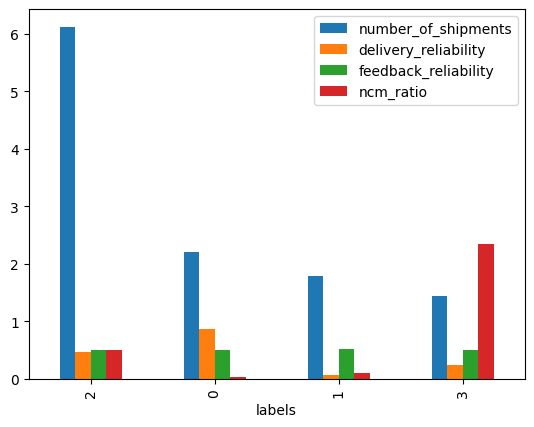

In [164]:
carrier_data.groupby('labels').agg({'number_of_shipments':'mean',
                                    'delivery_reliability':'mean',
                                    "feedback_reliability":'mean',
                                    'ncm_ratio': 'mean'}).sort_values(by='number_of_shipments',ascending=False).plot(kind='bar')

In [165]:
carrier_data.groupby('labels').agg({'number_of_shipments':'mean',
                                    'delivery_reliability':'mean',
                                    "feedback_reliability":'mean',
                                    'ncm_ratio': 'mean'}).sort_values(by='number_of_shipments',ascending=False)

,number_of_shipments,delivery_reliability,feedback_reliability,ncm_ratio
labels,,,,
2,6.119679,0.465698,0.497948,0.498550
0,2.201013,0.873541,0.498624,0.040262
1,1.791966,0.064861,0.513056,0.106767
3,1.434375,0.240320,0.503475,2.338795


### Carrier Performance Segmentation (4 Clusters – Operational KPIs Only)

| Segment Name           | Included Labels | Key Traits                                                                                                    | Recommendations                                                                                                                                                           |
|------------------------|-----------------|---------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Volume Powerhouses** | 2               | Highest volume (6.12 avg. shipments), moderate feedback (~50%), but only 46.6% delivery reliability and very high NCM (49.9%) | These carriers move the most freight but generate the most problems. Negotiate volume discounts while enforcing strict improvement SLAs (target >80% delivery and <10% NCM within 12 months). Biggest lever for overall performance gains. |
| **Reliable Scalers**   | 0               | Low–medium volume (2.2 avg.), excellent delivery reliability (87.4%), best-in-class NCM (4.0%), moderate feedback (~50%)      | Hidden gems that prove high reliability is possible. Actively shift more volume here. Offer preferred-partner status, longer contracts, and rate premiums if needed. Target: grow to 25–30% of total portfolio. |
| **Very Unreliable**    | 1               | Very low volume (1.8 avg.), catastrophically low delivery reliability (6.5%), elevated NCM (10.7%), moderate feedback (~51%) | Actively hurting KPIs and customer satisfaction. Immediate 90-day performance-improvement plan or orderly phase-out. Use only as last-resort overflow (<5% allocation).   |
| **Disastrous / Blacklist** | 3           | Lowest volume (1.4 avg.), poor delivery (24.0%), moderate feedback (~50%), extreme NCM (233.9% – >2 issues per shipment)   | Stop using immediately unless no alternative exists. Full blacklist recommended. Audit past claims/penalties and recover costs where possible. Target allocation = 0%.   |

#### Quick Wins for Procurement / Vendor Management
- Re-allocate 20–30% of volume from **Volume Powerhouses** → **Reliable Scalers**
- Place **Very Unreliable** on watchlist / exit plan
- Blacklist **Disastrous** carriers entirely
- Use these 4 segments as your new carrier scorecard tiers going forward